In [2]:
import numpy as np 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import os
import cv2

In [3]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' -q

from pycocotools.coco import COCO

In [4]:
#reading the annoattion file
coco = COCO('data/trainval/annotations/bbox-annotations.json')

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [5]:
#generate target
def generate_target(img_ids):
    """Generate the target dictionary for each image_id.

    Args:
        img_ids: (int) image_id number of the whole dataset
        
    Returns:
        (str) filename : 'image001.png'
        (dict) target :{'boxes':[[xmin,ymin,xmax,ymax],.....],'labels':[0,...],'image_id','1'}
    """
    #get the annotations for each image_ids
    annotation_ids = coco.getAnnIds(img_ids)
    annotations = coco.loadAnns(annotation_ids)
    image_meta = coco.loadImgs(annotations[0]["image_id"])[0]
    boxes=[]
    labels=[]
    for ann in annotations:
        x,y,w,h = ann['bbox']
        if w!=0  and h!=0:
            bbox = [x,y,x+w,y+h]
            boxes.append(bbox)
            labels.append(ann['category_id'])
    target = {}
    target["boxes"] = boxes    
    target["labels"] = labels
    return image_meta["file_name"], target

In [6]:
img_ids = range(0, len(os.listdir('data/trainval/images/')))
data={'image_id':[], 'boxes':[],'labels':[],'number_of_boxes':[],'width':[],'height':[],'class1':[],'class2':[]}
for idx in img_ids:
    image_name, target = generate_target(idx)
    data['image_id'].append(image_name)
    img_path = os.path.join("data/trainval/images/", image_name)
    img = Image.open(img_path)
    w, h = img.size
    boxes, labels, number_of_boxes = target['boxes'],target['labels'], len(target['boxes'])
    data['boxes'].append(boxes)
    data['labels'].append(labels)
    data['number_of_boxes'].append(number_of_boxes)
    data['width'].append(w)
    data['height'].append(h)
    data['class1'].append(len(np.where(np.array(labels)==1)[0]))
    data['class2'].append(len(np.where(np.array(labels)==2)[0]))
    
    
df = pd.DataFrame(data)
df.head()

,image_id,boxes,labels,number_of_boxes,width,height,class1,class2
0,image_000000001.jpg,"[[846, 145, 992, 622], [848, 216, 1023, 767], ...","[1, 1, 2, 2]",4,1024,768,2,2
1,image_000000002.jpg,"[[488, 281, 516, 352], [26, 283, 171, 358], [5...","[1, 2, 2]",3,1024,576,1,2
2,image_000000003.jpg,"[[8, 0, 88, 609], [57, 32, 208, 288], [167, 0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]",12,1024,683,11,1
3,image_000000004.jpg,"[[454, 188, 558, 305], [112, 139, 908, 550]]","[1, 2]",2,1024,675,1,1
4,image_000000005.jpg,"[[221, 718, 273, 840], [305, 766, 366, 879], [...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2]",10,1024,926,9,1


In [7]:
print('Total number of images in the dataset: ', len(df))

Total number of images in the dataset:  2239


Number of Unique heights and widths: 98, 233


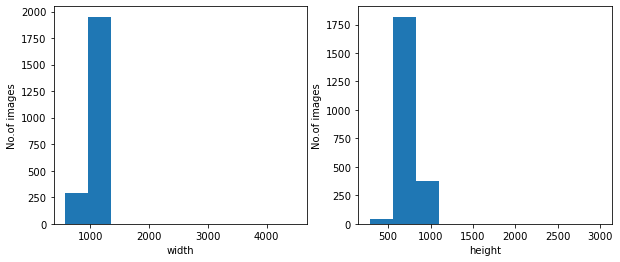

In [8]:
print(f'Number of Unique heights and widths: {len(df["width"].unique())}, {len(df["height"].unique())}')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['width'], bins=10)
plt.xlabel('width')
plt.ylabel('No.of images')
plt.subplot(1,2,2)
plt.hist(df['height'], bins=10)
plt.xlabel('height')
plt.ylabel('No.of images')
plt.show()

In [9]:
print('total boxes  :', df['number_of_boxes'].sum(), {'person': df['class1'].sum(), 'car':df['class2'].sum()})

total boxes  : 16769 {'person': 10797, 'car': 5972}


In [10]:
print(f"Total Bboxes: {df['number_of_boxes'].sum()}")

Total Bboxes: 16769


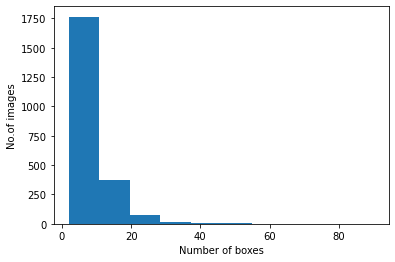

In [11]:
plt.hist(df['number_of_boxes'], bins=10)
plt.xlabel('Number of boxes')
plt.ylabel('No.of images')
plt.show()

In [12]:
print('Summary of data:  ')

print('Number of images:', len(df))
print('Avg. number of person boxes per image:', int(df['class1'].mean() ))
print('Avg. number of car boxes per image:', int(df['class2'].mean()) )
print('All images have different dimensions betweent the range of height:', df['height'].min(), 'to' ,df['height'].max(), ' and width:', df['width'].min(), 'to', df['width'].max())
print('Number of minimum bounding boxes',df['number_of_boxes'].min())
print('Number of maximum bounding boxes', df['number_of_boxes'].max())

Summary of data:  
Number of images: 2239
Avg. number of person boxes per image: 4
Avg. number of car boxes per image: 2
All images have different dimensions betweent the range of height: 282 to 3000  and width: 575 to 4496
Number of minimum bounding boxes 2
Number of maximum bounding boxes 90


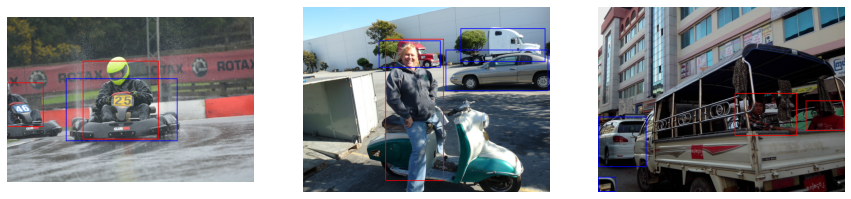

In [13]:

def show_images(images, num = 3):
    """Generate visulaization of bounding boxes in the data with images.

    Args:
        images: (list) image ids of the images in dataset
        num: (int) number of images to be shown at random
    Returns:
        Plot with vis
    """
    count=1
    plt.figure(figsize = (15,15))
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join('data/trainval/images', image_id)
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes =df[df['image_id'] == image_id]['boxes']
        labels = df[df['image_id'] == image_id]['labels']
        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox,labels in zip(bboxes, labels):  
            for box, label in zip(bbox, labels):
                if label==1:
                    draw.rectangle([box[0], box[1], box[2],box[3]], width=3,outline ="red")
                else:
                    draw.rectangle([box[0], box[1], box[2],box[3]], width=3,outline ="blue")

        plt.subplot(1,3,count)
        plt.imshow(image)
        plt.axis('off')
        count=count+1
show_images(df['image_id'].unique())

----